<a href="https://colab.research.google.com/github/FadelYang/craft-it-object-detection-model/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#importing required Libraries
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Preparing Dataset

## Mount to Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd drive/MyDrive/'Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


## Connect To Kaggle And Download Datasets

this code is used to connect Google Colab and Kaggle, run it just once for download the datasets from kaggle, uncomment it first if you want to run these cell below

In [6]:
# # copy kaggle.json to /root/.kaggle/ folder so that kaggle cli can access it.
# !mkdir /.kaggle
# !mv kaggle.json /.kaggle
# !mv /.kaggle /root/
# !chmod 600 ~/.kaggle/kaggle.json

In [7]:
# # Download datasets from Kaggle.
# !kaggle datasets download -d kshitizgajurel042/recyclable-images-with-annotations-for-detection

In [8]:
# !unzip recyclable-images-with-annotations-for-detection.zip

In [9]:
# !mv 'Final Data' recyclable-images-datasets

## Preprocess Dataset

## Prepare Dataset To Correct Format

In [41]:
# Print image and the annotation
data_dir = os.path.join(os.getcwd(), 'recyclable-images-datasets')

import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def load_dataset(image_folder, label_folder):
  image_paths = sorted([os.path.join(image_folder, filename) for filename in os.listdir(image_folder)], key=natural_sort_key)
  label_paths = sorted([os.path.join(label_folder, filename) for filename in os.listdir(label_folder)], key=natural_sort_key)

  images = tf.data.Dataset.from_tensor_slices(image_paths)
  labels = tf.data.Dataset.from_tensor_slices(label_paths)

  dataset = tf.data.Dataset.zip((images, labels))
  return dataset

# Path to your image and label directories
image_folder = os.path.join(data_dir, 'images', 'train')
label_folder = os.path.join(data_dir, 'labels', 'train')

# Load the dataset
dataset = load_dataset(image_folder, label_folder)

# Print the first five image paths and label paths
for image_path, label_path in dataset:
  print("Image Path:", image_path.numpy())
  print("Label Path:", label_path.numpy())

Image Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/images/train/1.jpg'
Label Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/labels/train/1.txt'
Image Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/images/train/2.jpg'
Label Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/labels/train/2.txt'
Image Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/images/train/3.jpg'
Label Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/labels/train/3.txt'
Image Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/images/train/4.jpg'
Label Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/labels/train/4.txt'
Image Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/images/train/5.jpg'
Label Path: b'/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/labels/train/5.txt'


In [37]:
# Define function for read annotations
# since the annotations are in .txt file, we need to access them one by one and
# insert it in one variable.
def read_annotations(annotation_file):
  with open(annotation_file, 'r') as file:
    lines = file.readlines()
    annotations = []
    for line in lines:
      parts = line.strip().split()
      class_label = parts[0]
      x_min, y_min, x_max, y_max = map(float, parts[1:])
      annotations.append({
          'class_label': class_label,
          'x_min': x_min,
          'y_min': y_min,
          'x_max': x_max,
          'y_max': y_max
      })
    return annotations

In [50]:
# Preprocessing data
def preprocess_data(data_dir, image_size=(640, 480)):
  images = []
  annotations = []

  image_folder = os.path.join(data_dir, 'images', 'train')
  label_folder = os.path.join(data_dir, 'labels', 'train')
  print(image_folder)

  dataset = load_dataset(image_folder, label_folder)

  for image_path, label_path in dataset:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0  # Normalize image

    annotation_path = label_path.numpy().decode()
    if os.path.exists(annotation_path):
      annotation = read_annotations(annotation_path)
      images.append(image.numpy())
      annotations.append(annotation)
    else:
      print(f'Annotation file for image {image_path} not found')

  return np.array(images), annotations

In [ ]:
images, annotations = preprocess_data(data_dir)

/content/drive/MyDrive/Colab Notebooks/recyclable-images-datasets/images/train


In [ ]:
# check images and annotations
print(images[0])
for i in range(10):
  print(annotations[i])

In [45]:
def create_tf_dataset(images, annotations):
  def generator():
    for image, ann in zip(images, annotations):
      classes = np.array([a['class_label'] for a in ann], dtype=np.int32)
      boundary_boxes = np.array(
          [[a['x_min'], a['y_min'], a['x_max'], a['y_max']] for a in ann],
          dtype=np.float32
      )
      yield image, (classes, boundary_boxes)

  dataset = tf.data.Dataset.from_generator(
      generator,
      output_signature=(
          tf.TensorSpec(shape=(640, 480, 3), dtype=tf.float32),
          (
              tf.TensorSpec(shape=(None,), dtype=tf.int32),
              tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
          )
      )
  )

  return dataset

In [46]:
train_dataset = create_tf_dataset(images, annotations)

In [47]:
for image, (classes, boxes) in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Classes:", classes)
    print("Boxes:", boxes)

Image shape: (224, 224, 3)
Classes: tf.Tensor([8], shape=(1,), dtype=int32)
Boxes: tf.Tensor([[0.435156 0.730469 0.301563 0.251563]], shape=(1, 4), dtype=float32)


## Visualize Corrected Format Dataset

In [48]:
LABEL_NAMES = [
    'Aluminium Foil',
    'Bottle',
    'Bottle Cap',
    'Can',
    'Carton',
    'Cup',
    'Paper',
    'Straw',
    'Plastic Bag',
    'Wrapper'
]

def visualize_data(images, classes_list, boxes_list, image_size=(640, 480)):
  for image, classes, boxes in zip(images, classes_list, boxes_list):
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Draw the boundary boxes
    for cls, box in zip(classes, boxes):
      x_min, y_min, x_max, y_max = box
      # Scale up first since the image_size got normalize
      x_min *= image_size[0]
      y_min *= image_size[1]
      x_max *= image_size[0]
      y_max *= image_size[1]
      width = x_max - x_min
      height = y_max - y_min
      rect = patches.Rectangle(
          (x_min, y_min),
          width,
          height,
          linewidth=1,
          edgecolor='r',
          facecolor='none'
      )
      print((cls))
      ax.add_patch(rect)
      label_name = LABEL_NAMES[int(cls)]
      ax.text(
          x_min,
          y_min,
          label_name,
          color='yellow',
          fontsize=12,
          backgroundcolor='black'
      )

    plt.show()

def visualize_dataset(dataset, num_examples=5, image_size=(640, 480)):
  images = []
  classes_list = []
  boxes_list = []
  for image, (classes, boxes) in dataset.take(num_examples):
    images.append(image.numpy())
    classes_list.append(classes.numpy())
    boxes_list.append(boxes.numpy())

  visualize_data(images, classes_list, boxes_list, image_size)

8


<Figure size 640x480 with 0 Axes>

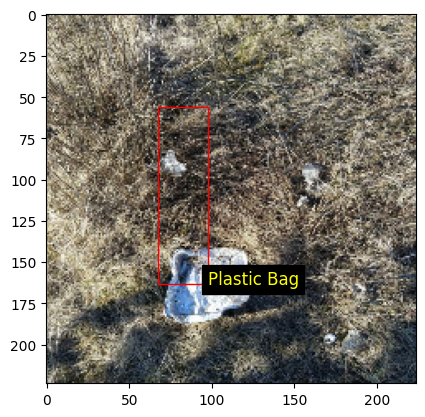

<Figure size 640x480 with 0 Axes>

3
3
1
8


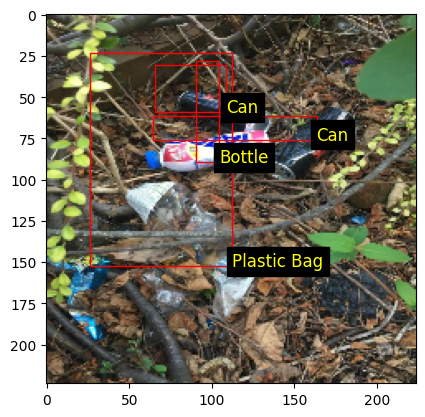

8


<Figure size 640x480 with 0 Axes>

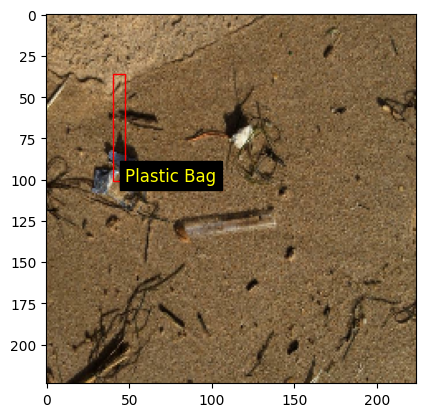

8


<Figure size 640x480 with 0 Axes>

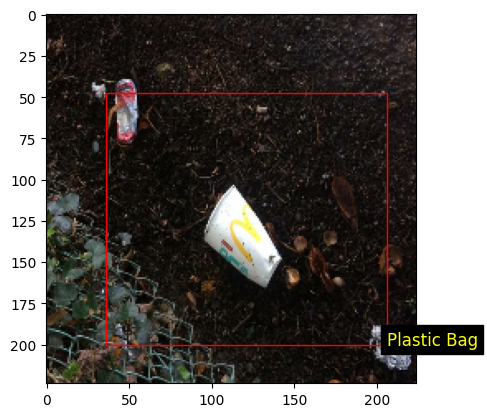

8


<Figure size 640x480 with 0 Axes>

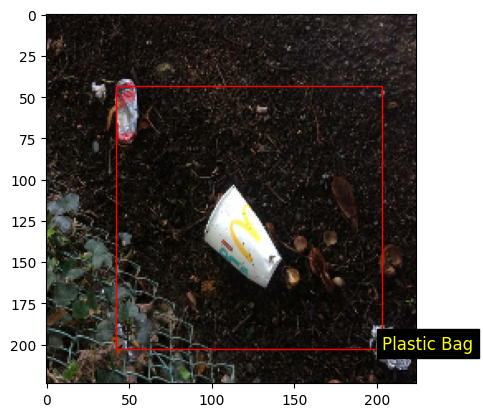

In [49]:
# print(train_dataset)
visualize_dataset(train_dataset)